In [1]:
import sys

sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import botbacktester as bbt
import botbacktester.enums as E

%load_ext autoreload
%autoreload 2

In [2]:
!pip install Ta-Lib

In [3]:
import talib

In [4]:
df = pd.read_csv("data/gmo_btc_jpy_1min.csv")
df['timestamp'] = pd.to_datetime(df.timestamp)
df = df.set_index("timestamp").sort_index()

df = bbt.utils.resample_candle(df, 15)  # 15分足
df

,open,high,low,close,volume
timestamp,,,,,
2021-04-14 21:00:00,6797189.0,6831263.0,6794913.0,6825183.0,51.40
2021-04-14 21:15:00,6825757.0,6842000.0,6809014.0,6835000.0,64.38
2021-04-14 21:30:00,6835755.0,6847833.0,6825721.0,6847435.0,39.50
2021-04-14 21:45:00,6847235.0,6847235.0,6819669.0,6840210.0,53.24
2021-04-14 22:00:00,6840952.0,6853035.0,6819717.0,6843387.0,43.82
...,...,...,...,...,...
2022-01-31 11:15:00,4297714.0,4303420.0,4290043.0,4292317.0,31.31
2022-01-31 11:30:00,4292086.0,4293253.0,4273015.0,4273585.0,53.65
2022-01-31 11:45:00,4272918.0,4315400.0,4262766.0,4306001.0,155.41


In [5]:
alpha = 0.5
df['atr'] = talib.ATR(df.high, df.low, df.close)
df['sell_price'] = df.close + df.atr * alpha
df['buy_price'] = df.close - df.atr * alpha

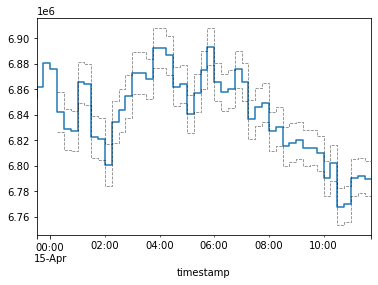

In [6]:
begin = 10
n = 50

df_plot = df.iloc[begin:begin+n]

df_plot.close.plot(drawstyle="steps")
p = dict(drawstyle="steps", color="black", alpha=0.5, linestyle="--", linewidth=0.8)
df_plot.buy_price.plot(**p)
df_plot.sell_price.plot(**p)
plt.show()

In [7]:
tester = bbt.BackTester(df)

In [8]:
for i, item in tester.start():
    buy_position = tester.positions(side=E.Side.BUY)
    sell_position = tester.positions(side=E.Side.SELL)

    assert len(buy_position) <= 1
    assert len(sell_position) <= 1

    if len(buy_position) == 0:
        tester.entry(E.Side.BUY, E.ExecutionType.LIMIT, price=item['buy_price'], expire_seconds=60)
    else:
        tester.exit(buy_position[0], E.ExecutionType.LIMIT, price=item['sell_price'], expire_seconds=60)

    if len(sell_position) == 0:
        tester.entry(E.Side.SELL, E.ExecutionType.LIMIT, price=item['sell_price'], expire_seconds=60)
    else:
        tester.exit(sell_position[0], E.ExecutionType.LIMIT, price=item['buy_price'], expire_seconds=60)

100%|██████████| 27783/27783 [00:02<00:00, 10097.57it/s]


In [9]:
df_result = tester.get_result_df()

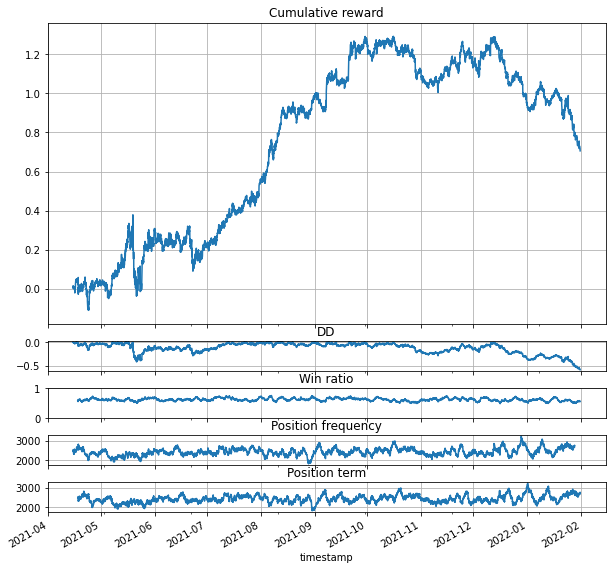

In [10]:
bbt.evaluate.report(df_result)